### Authors: </br>
Ruy Guzmán </br>
Fernanda de León </br>
Karla Mondragón

# LSTM

In [11]:
pip install tensorflow

  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.1
    Uninstalling protobuf-4.25.1:
      Successfully uninstalled protobuf-4.25.1
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\karla\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [12]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Dataset Overview

In [21]:
df_msft = pd.read_csv('../database/ticker_MSFT.csv')
df_goog = pd.read_csv('../database/ticker_GOOG.csv')
df_v = pd.read_csv('../database/ticker_V.csv')

In [22]:
df_v["Date"] = pd.to_datetime(df_v.Date)
df_v = df_v.set_index("Date")
df_v

,Open,High,Low,Close,Adj Close,Volume,Symbol
Date,,,,,,,
2021-12-06,198.770004,204.220001,197.740005,202.679993,199.573517,10722100,V
2021-12-07,206.000000,207.940002,205.889999,207.369995,204.191650,11897200,V
2021-12-08,207.660004,209.479996,205.710007,208.990005,205.786804,11749200,V
2021-12-09,208.520004,212.199997,207.169998,211.389999,208.150009,10176800,V
2021-12-10,211.899994,214.250000,210.860001,213.399994,210.129211,8882700,V
...,...,...,...,...,...,...,...
2023-11-29,253.919998,256.070007,253.520004,254.229996,254.229996,4955100,V
2023-11-30,254.250000,256.769989,253.169998,256.679993,256.679993,6874700,V
2023-12-01,255.789993,256.910004,253.899994,256.450012,256.450012,3939400,V


In [23]:
def plotVariables(df,vars, title):
    df[vars].plot(
        figsize=(15,7), 
        title=title,
        subplots = True
    )

    plt.show()

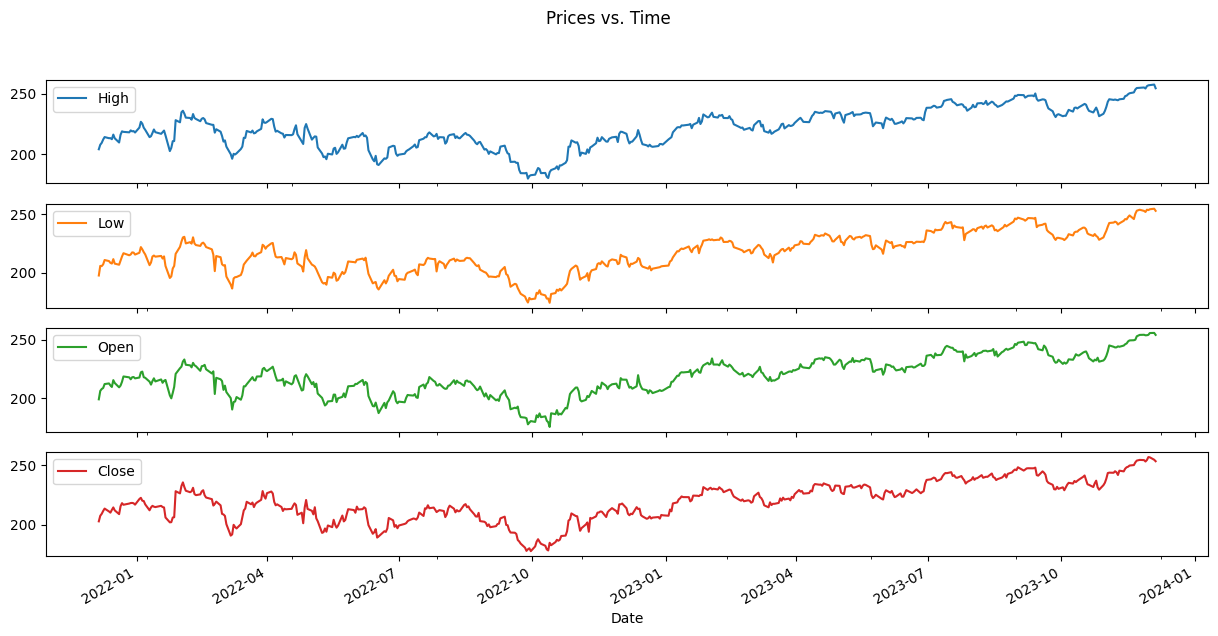

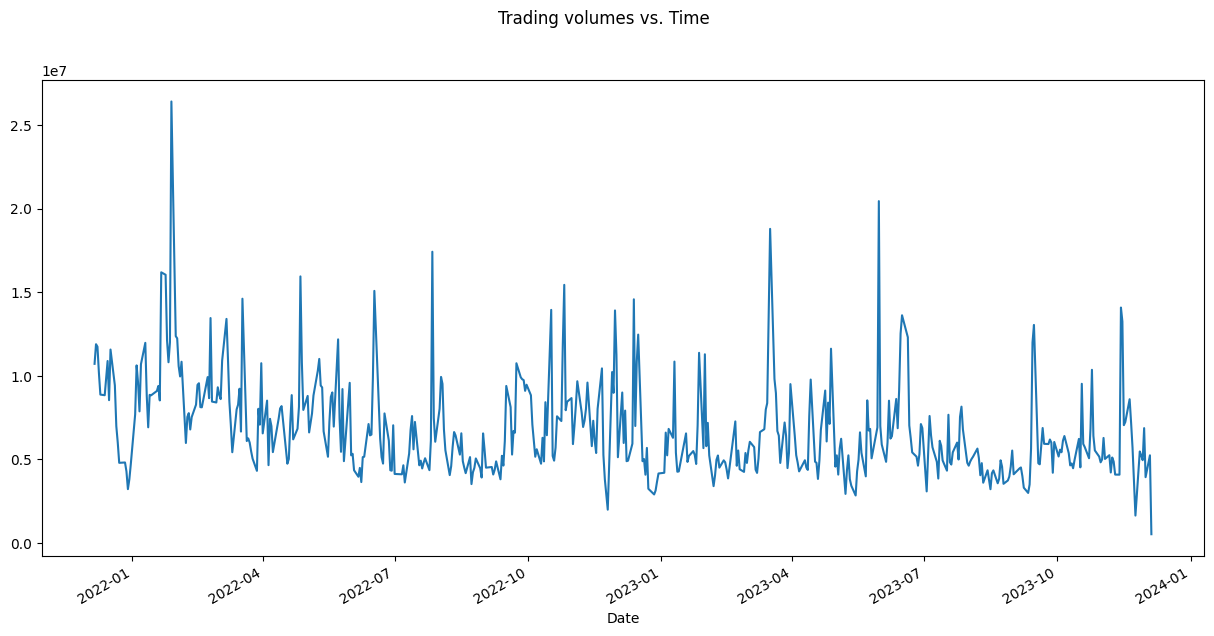

In [24]:
plotVariables(df_v,['High','Low','Open','Close'],'Prices vs. Time')
plotVariables(df_v,'Volume','Trading volumes vs. Time')

In [25]:
df_v = df_v.drop(columns=['Open','High','Low'])
df_v

,Close,Adj Close,Volume,Symbol
Date,,,,
2021-12-06,202.679993,199.573517,10722100,V
2021-12-07,207.369995,204.191650,11897200,V
2021-12-08,208.990005,205.786804,11749200,V
2021-12-09,211.389999,208.150009,10176800,V
2021-12-10,213.399994,210.129211,8882700,V
...,...,...,...,...
2023-11-29,254.229996,254.229996,4955100,V
2023-11-30,256.679993,256.679993,6874700,V
2023-12-01,256.450012,256.450012,3939400,V


## Data Preprocessing

In [26]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_v['Close'].values.reshape(-1,1))
scaled_data

array([[0.31671516],
       [0.37605975],
       [0.39655842],
       [0.42692656],
       [0.45235987],
       [0.42224486],
       [0.40908519],
       [0.43856769],
       [0.46463371],
       [0.43312681],
       [0.39339507],
       [0.47741379],
       [0.51005964],
       [0.49310391],
       [0.50588399],
       [0.5111984 ],
       [0.51271675],
       [0.50892069],
       [0.49424286],
       [0.55396684],
       [0.56700004],
       [0.53587254],
       [0.53270918],
       [0.49740622],
       [0.43426557],
       [0.46476036],
       [0.48158944],
       [0.47260542],
       [0.46842977],
       [0.48158944],
       [0.46855624],
       [0.46438078],
       [0.35783879],
       [0.30621299],
       [0.30811093],
       [0.35707961],
       [0.36062255],
       [0.63709992],
       [0.61394414],
       [0.69226885],
       [0.7309883 ],
       [0.68189295],
       [0.64203475],
       [0.62647109],
       [0.63634075],
       [0.67341518],
       [0.60660513],
       [0.595

In [27]:
# Set the number of days used for prediction
prediction_days = 30

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [28]:
def LSTM_model():
    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))
    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

## Training

In [29]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam', 
    loss='mean_squared_error'
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 

In [30]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2, 
    save_best_only = True
)

model.fit(
    x_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25

15/15 [==============================] - 7s 35ms/step - loss: 0.0839
Epoch 2/25
15/15 [==============================] - 1s 37ms/step - loss: 0.0268
Epoch 3/25
15/15 [==============================] - 1s 38ms/step - loss: 0.0195
Epoch 4/25
15/15 [==============================] - 1s 74ms/step - loss: 0.0185
Epoch 5/25
15/15 [==============================] - 1s 72ms/step - loss: 0.0145
Epoch 6/25
15/15 [==============================] - 1s 75ms/step - loss: 0.0138
Epoch 7/25
15/15 [==============================] - 1s 73ms/step - loss: 0.0138
Epoch 8/25
15/15 [==============================] - 1s 74ms/step - loss: 0.0135
Epoch 9/25
15/15 [==============================] - 1s 75ms/step - loss: 0.0136
Epoch 10/25
15/15 [==============================] - 1s 74ms/step - loss: 0.0124
Epoch 11/25
15/15 [==============================] - 1s 73ms/step - loss: 0.0123
Epoch 12/25
15/15 [==============================] - 1s 75ms/step - loss: 0.0124
Epoch 13/25
15/15 [=================

### ignorar por ahora

In [13]:
train = df_v.loc[df_v.index < '2023-04-01']
test = df_v.loc[df_v.index >= '2023-04-01']

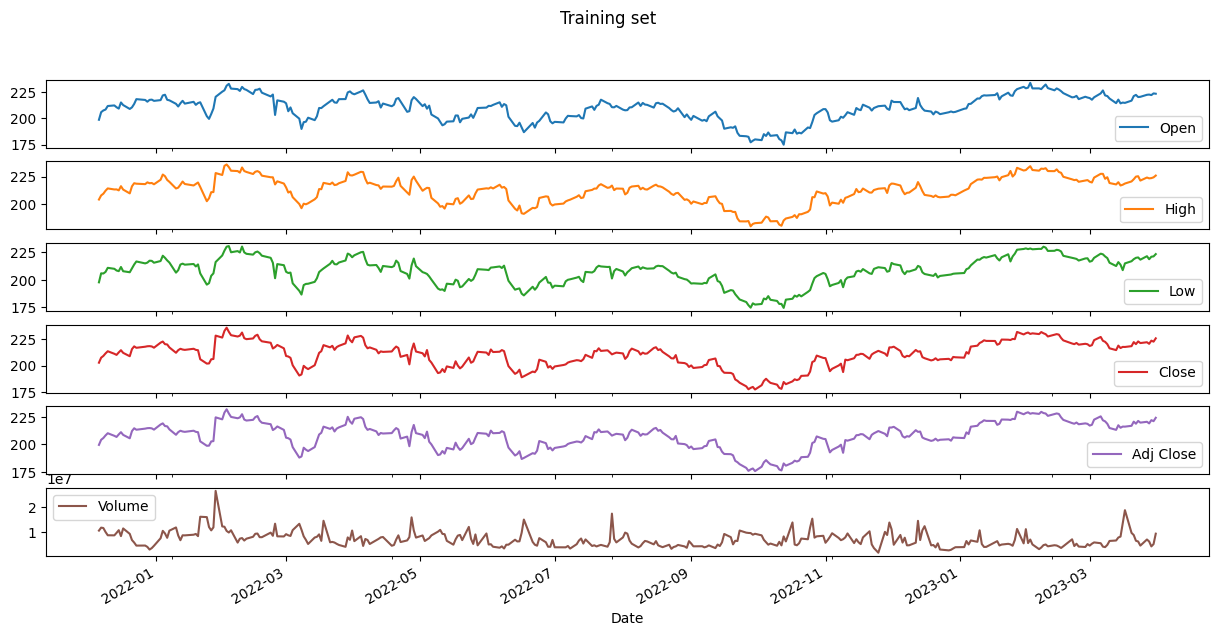

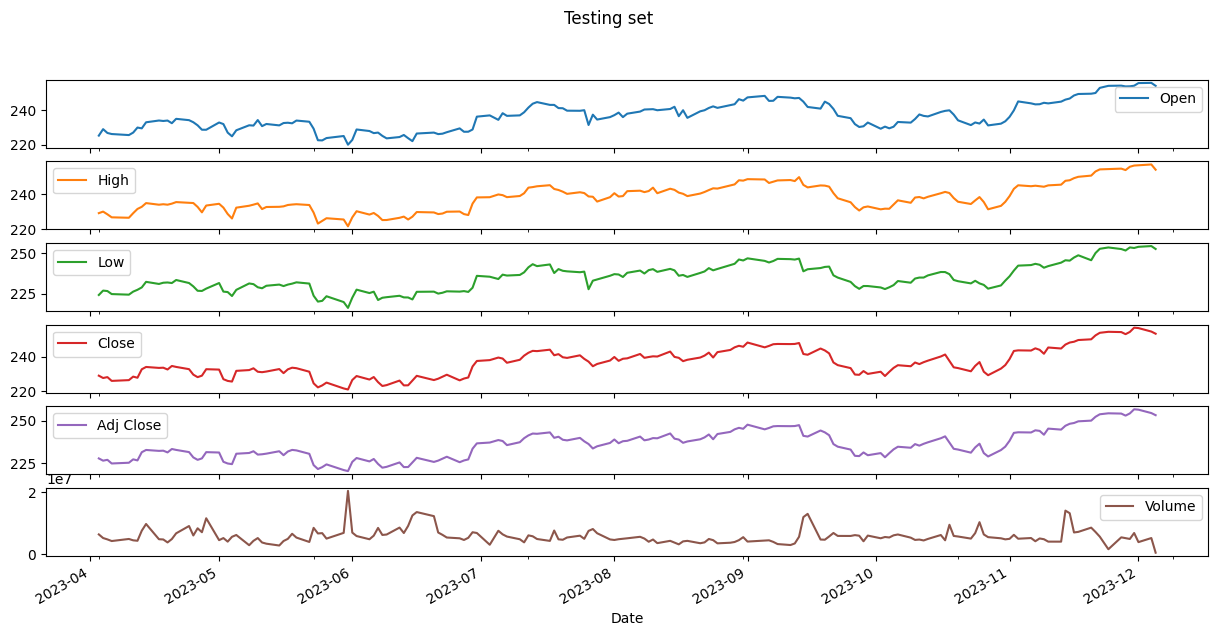

In [14]:
plotVariables(train,list(train.columns.values),'Training set')
plotVariables(test,list(test.columns.values),'Testing set')